# Computing the Power spectrum of a Dyablo Cosmological Simulation
In this notebook, 
- we will extract particle positions from a Dyablo file
- compute its CIC density
- compute its Power spectrum P(k)
- compare it with the Linear and Non-Linear prediction of CAMB

CAMB is described here: https://camb.readthedocs.io and is a requirement for the comparison. This notebook uses the CosmoUtils library, also available on the wiki.

Keep in mind :
+ early timestep seems important (small da, da <1.01) : UNCLEAR, REF used 1.05
+ CGEPS ~0.01 seems enough
+ update Cosmoutils.py on wiki, removed noise corrector to probe IC as well
+ added error on CIC estimate of Pk
+ beware of cosmic variance...
+ check the influence of sigstart and offvelb in grafic1.inc : offvelb/offvelc = 1, sigstart = 0.15 seem ok for 164 Mpc/h 256^3
+ confirmed ok of 164 Mpc/h 256^3 at z=0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from configparser import ConfigParser
from CosmoUtils import *
import h5py
import camb
from camb import model, initialpower

Read Particles from snaphsot

In [4]:
# nb_iter, zsnap = ["0000000",26.1272]
# nb_iter, zsnap = ["0000250",2.47551]
nb_iter, zsnap = ["0002850",0.0]

filename = f"cosmo_particles_particles_iter{nb_iter}.h5"

fpart = h5py.File(f'datastageM2/{filename}', 'r')

positions = np.array(fpart['coordinates'])
print(np.shape(positions))

x=positions[:,0]
y=positions[:,1]
z=positions[:,2]
Npart=np.size(x)

# Uncomment if velocities are available in the Dyablo output
#vx = np.array(fpart['vx'])
#vy = np.array(fpart['vy'])
#vz = np.array(fpart['vz'])

(16777216, 3)


CIC DENSITY CONTRAST ESTIMATE

16777216.0


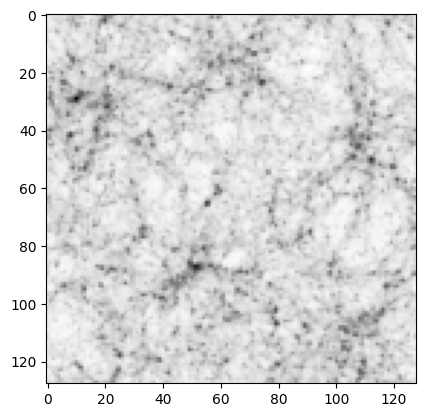

In [5]:
NC=128 # the grid sampling of the CIC density estimate
deltadm=part2cic(positions,NC) # returns the density contrast
plt.figure()
plt.imshow(np.log10(np.sum(deltadm+1,axis=2)),cmap='Greys')

In [9]:
np.shape(deltadm)

(128, 128, 128)

## Let's compute the power spectrum P(k). 

In [43]:
# power spectrum from particles
nsamp =64 # frequency sampling for the power spectrum
pksimdm_c,ksimdm_c,esimdm_c=field2Pk_CIC(deltadm,Lbox,nsamp=nsamp,Npart=Npart) # here Lbox in Mpc
pksimdm_c=pksimdm_c*(h**3) # -> (Mpc/h)**3
esimdm_c=esimdm_c*(h**3) # -> (Mpc/h)**3
ksimdm_c=ksimdm_c/h # ->(h/Mpc)


0.0 8.419468311620646


## IC power spectra (if required)

In [8]:
#initial power spectrum (analytical)
data=np.loadtxt('./ic/power_ini.dat')
k0=data[:,0]
pk0=data[:,1]

In [9]:
#initial power spectrum (from field)
deltag,gLbox,gaexp,gom,gov,gH0=readgrafic("./ic/ic_deltab")
print(np.std(deltag))
pkic,kic=field2Pk(deltag,Lbox,nsamp=200) # here Lbox in Mpc
pkic=pkic*(h**3) # -> (Mpc/h)**3
kic=kic/h # ->(h/Mpc)

0.17900269
0.0 3.2856461703885445


## PLOT

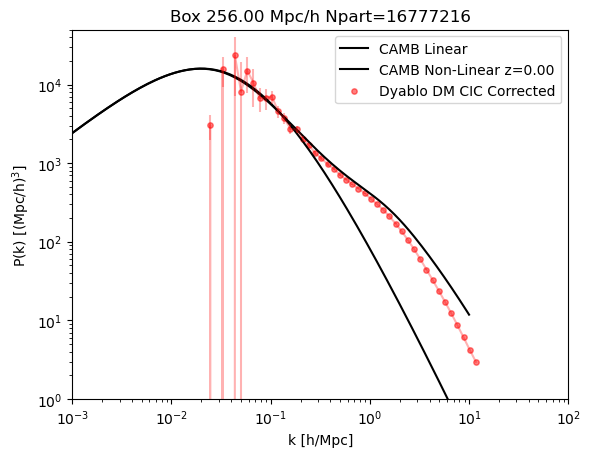

In [44]:
plt.figure()
plt.loglog(kh,pk[-1,:],'k',label='CAMB Linear')
plt.loglog(kh_nl,pk_nl[-1,:],'k',label='CAMB Non-Linear z={:4.2f}'.format(z))
plt.scatter(ksimdm_c,pksimdm_c,label='Dyablo DM CIC Corrected',c='r',s=15.0,alpha=0.5)
plt.errorbar(ksimdm_c,pksimdm_c,esimdm_c*3,alpha=0.3,c='r')
#plt.loglog(k0,pk0*(2*np.pi)**3,label='grafic pow spec')
#plt.scatter(kic,pkic,c='g',s=15.5,marker='d',label=' IC',alpha=0.5)
plt.ylim([1e0,5e4])
plt.xlim([1e-3,100])
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P(k) [(Mpc/h)$^3$]')
plt.title('Box {:5.2f} Mpc/h Npart={:d}'.format(Lbox*h,Npart))
plt.legend()

## Let's Compute sigma 8 at current redshift z

In [11]:
import scipy.integrate as integ
# We compute sigma 8 for cross-check
R=8 #Mpc/h

x=kh*R
w=3*(np.sin(x)-x*np.cos(x))/x**3
pconv=pk[-1,:]/(2*np.pi)**3 # we convert PCAMB -> PGRAFIC
sig_camb=np.sqrt(integ.trapz((pconv)*4*np.pi*kh**2*w**2,kh)) # should be s8

print('sig_camb={:5.4f} should be {:5.4f} at z=0'.format(sig_camb,s8))


sig_camb=0.8345 should be 0.8344 at z=0
